<a href="https://colab.research.google.com/github/RoshMeh/Geol0069-24-25-End-of-year-assignment/blob/main/Deforestation_GEOL0069.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Deforestation Using Machine Learning

# Why It’s Useful (Problem Description)
Deforestation Detection and Mapping in the Amazon Rainforest and Congo Basin (DRC)

This notebook aims to detect and map deforestation in two critical regions of global concern: the **Amazon Rainforest (Brazil)** and the **Congo Basin (Democratic Republic of Congo)**. These regions are vital carbon sinks and biodiversity hotspots, but face increasing deforestation driven by logging, agriculture, and land conversion. Deforestation in these areas contributes significantly to biodiversity loss, carbon emissions, and climate change. Detecting these changes using satellite imagery provides a scalable and timely approach to monitoring environmental impacts.

In this project, we use **Sentinel-2 multi-temporal optical imagery** to analyse forest cover changes between two time points (before and after deforestation events). We implement both **traditional remote sensing techniques** (e.g., NDVI difference) and **deep learning models** (e.g., Siamese Convolutional Neural Networks) to improve detection accuracy.

## Key steps include:
- Loading and preprocessing Sentinel-2 imagery from the Amazon and Congo Basin.
- Calculating baseline NDVI differences to highlight areas of change.
- Building and training a deep learning model for change detection.
- Visualising results and evaluating model performance.
- Estimating the environmental cost of model training.

This notebook demonstrates the power of combining Earth Observation data with AI to support global forest monitoring, conservation efforts, and sustainable land management.


## Notebook Requirements

This notebook requires the following Python libraries:
- `rasterio`: for reading geospatial raster data.
- `numpy`: for numerical operations.
- `torch`, `torchvision`: for building and training the deep learning models.
- `scikit-learn`: for baseline machine learning methods and evaluation.
- `matplotlib`, `seaborn`: for data visualization and analysis.
- `codecarbon`: for estimating carbon dioxide (CO₂) emissions produced by running code, enabling an understanding of the environmental impact of computational tasks.

Before running the notebook, please ensure these libraries are installed. You can install them using the following command:

In [ ]:
!pip install rasterio numpy torch torchvision scikit-learn matplotlib seaborn

Seperated due to having to restart after installing

In [ ]:
!pip install codecarbon

If working in Google Colab or Jupyter, ensure that file paths are correctly specified to point to the downloaded Sentinel-2 imagery and that the necessary packages are installed in your environment.


## Data Description

In this project, we use **Sentinel-2 Level-1C/2A imagery**, which provides high-resolution optical images of Earth's surface. Sentinel-2 offers 13 spectral bands, including visible, near-infrared, and shortwave infrared bands, making it ideal for detecting vegetation changes such as deforestation.

For each region (**Amazon (Brazil)** and **Congo Basin (Democratic Republic of Congo)**), we import two multi-band images:
- **Before image**:  
  - Amazon: Captured on **2020-06-09**  
  - Congo Basin: Captured on **2019-07-19**
- **After image**:  
  - Amazon: Captured on **2021-06-14**  
  - Congo Basin: Captured on **2021-07-01**

These images will be used for:
- **Remote sensing index calculations** (e.g., NDVI) to highlight vegetation changes.
- **Deep learning model inputs** for change detection (Siamese CNN).

The dataset is sourced from the **Copernicus Open Access Hub** and processed from Sentinel-2 imagery. In practice, you may use the provided coordinates and dates to download images or load local copies for reproducibility.

| Region            | Coordinates            | Date (Before) | Date (After) | Layers Used                                      |
|-------------------|------------------------|---------------|--------------|--------------------------------------------------|
| Amazon (Brazil)   | -8.8525°, -63.7035°    | 2020-06-09    | 2021-06-14   | True Color, NDVI, Barren Soil, False Color 11-8-2|
| Congo Basin (DRC) | -0.1801°, 18.6301°     | 2019-07-19    | 2021-07-01   | True Color, NDVI, Barren Soil, False Color 11-8-2|



To access Sentinel-2 data stored in your Google Drive, you can mount the drive into Colab using the following code:

In [ ]:
   from google.colab import drive
   drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code imports the `EmissionsTracker` class from the `codecarbon` library and creates an instance of it to track carbon emissions. The `project_name` parameter is set to `"DeforestationDetection"`, which labels the emissions data for this specific project.

`tracker.start()` initiates the tracking process, which will monitor the energy consumption of the code that follows and estimate the resulting carbon dioxide (CO₂) emissions. This is useful for understanding and reducing the environmental impact of computational work.


In [ ]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(project_name="DeforestationDetection")
tracker.start()

## Sentinel-2 Data for Amazon and Congo Basin

This section connects to the **Copernicus Data Space Ecosystem (CDSE)** to query **Sentinel-2 Level-1C/2A imagery** for two key deforestation regions: the **Amazon Rainforest (Brazil)** and the **Congo Basin (Democratic Republic of Congo)**.

### Key Components:
- **Authentication:**  
  The script uses an access token and refresh token to authenticate requests. It handles token expiration and renewal automatically.
- **Geographic Focus:**  
  We define bounding polygons around the **Amazon (Brazil)** and **Congo Basin (DRC)** regions using their latitude and longitude coordinates. These polygons specify the areas of interest for the query.
- **Date Filtering:**  
  The query targets specific dates representing "before" and "after" deforestation events:
  - **Amazon (Before):** 2020-06-09
  - **Amazon (After):** 2021-06-14
  - **Congo Basin (Before):** 2019-07-19
  - **Congo Basin (After):** 2021-07-01
- **Cloud Cover Filter:**  
  To ensure data quality, we filter for images with **cloud cover ≤ 10%**.
- **Data Retrieval:**  
  The script makes authorized API calls to retrieve product metadata for Sentinel-2 scenes that match the specified criteria.
- **Output:**  
  The results are compiled into a **Pandas DataFrame**, displaying key metadata fields such as:
  - Product ID
  - Product Name
  - Collection
  - Content Date
  - Footprint geometry
  - Additional attributes (e.g., cloud cover)
  - Associated region (Amazon or Congo Basin)

### Why This Matters:
This approach automates the retrieval of **Sentinel-2 images** for our deforestation detection project, ensuring we have accurate, high-quality data for both study regions. It sets the foundation for further analysis, including NDVI calculation, change detection, and deep learning model training.


Note files are already downloaded so dont run again:

In [ ]:
from datetime import datetime
from shapely.geometry import Polygon
import numpy as np
import requests
import pandas as pd
import os

# Login credentials - change to your details
username = "*********mm@ucl.ac.uk"
password = "********"

# Define global tokens
access_token, refresh_token = None, None

# Get tokens
def get_access_and_refresh_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    tokens = response.json()
    return tokens["access_token"], tokens["refresh_token"]

# Refresh token
def refresh_access_token(refresh_token):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        "client_id": "cdse-public",
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    return response.json()["access_token"]

# Make authorized request
def make_api_request(url, headers=None):
    global access_token, refresh_token
    if not headers:
        headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    if response.status_code in [401, 403]:
        access_token = refresh_access_token(refresh_token)
        headers["Authorization"] = f"Bearer {access_token}"
        response = requests.get(url, headers=headers)
    return response

# Query Sentinel-2 products for a region and date range
def query_sentinel2_data(start_date, end_date, lat, lon, max_cloud=10):
    polygon = f"POLYGON(({lon-0.1} {lat-0.1}, {lon-0.1} {lat+0.1}, {lon+0.1} {lat+0.1}, {lon+0.1} {lat-0.1}, {lon-0.1} {lat-0.1}))"
    filter_string = (
        f"Collection/Name eq 'SENTINEL-2' and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T23:59:59.999Z and "
        f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/Value le {max_cloud})"
    )
    url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter={filter_string} and OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')&$top=100"
    )
    headers = {"Authorization": f"Bearer {access_token}"}
    response = make_api_request(url, headers=headers)
    if response.status_code == 200:
        return pd.DataFrame(response.json()["value"])
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return pd.DataFrame()

# Download a single product
def download_single_product(product_id, file_name, access_token, download_dir):
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)
    response = session.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        output_file_path = os.path.join(download_dir, file_name + ".zip")
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

# Authenticate
access_token, refresh_token = get_access_and_refresh_token(username, password)

# Define regions and dates
regions = {
    "Amazon_Brazil_Before": {"lat": -8.8525, "lon": -63.7035, "start": "2020-06-09", "end": "2020-06-09"},
    "Amazon_Brazil_After": {"lat": -8.8525, "lon": -63.7035, "start": "2021-06-14", "end": "2021-06-14"},
    "Congo_DRC_Before": {"lat": -0.1801, "lon": 18.6301, "start": "2019-07-19", "end": "2019-07-19"},
    "Congo_DRC_After": {"lat": -0.1801, "lon": 18.6301, "start": "2021-07-01", "end": "2021-07-01"},
}

# Save directory
download_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1"
os.makedirs(download_dir, exist_ok=True)

# Query, save metadata, and download one product per query
all_data = []
for key, info in regions.items():
    print(f"Querying {key}...")
    data = query_sentinel2_data(info["start"], info["end"], info["lat"], info["lon"])
    if not data.empty:
        data["Region"] = key
        all_data.append(data)

        # Save metadata CSV for this query
        metadata_csv = os.path.join(download_dir, f"metadata_{key}.csv")
        data.to_csv(metadata_csv, index=False)
        print(f"Metadata for {key} saved to {metadata_csv}")

        # Download first product of this query
        product_id = data['Id'].iloc[0]
        file_name = data['Name'].iloc[0]
        print(f"Downloading {file_name} for {key}...")
        download_single_product(product_id, file_name, access_token, download_dir)
    else:
        print(f"No data found for {key}.")

# Combine all metadata into one CSV
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_csv = os.path.join(download_dir, "sentinel2_metadata_amazon_congo_combined.csv")
    combined_df.to_csv(combined_csv, index=False)
    print(f"Combined metadata saved to {combined_csv}")
else:
    print("No data retrieved.")


Querying Amazon_Brazil_Before...
Metadata for Amazon_Brazil_Before saved to /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/metadata_Amazon_Brazil_Before.csv
Downloaded: /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/S2A_MSIL2A_20200609T142741_N0500_R053_T20LMR_20230327T094707.SAFE.zip
Querying Amazon_Brazil_After...
Metadata for Amazon_Brazil_After saved to /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/metadata_Amazon_Brazil_After.csv
Downloaded: /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/S2A_MSIL2A_20210614T142731_N0500_R053_T20LMR_20230321T232725.SAFE.zip
Querying Congo_DRC_Before...
Metadata for Congo_DRC_Before saved to /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/metadata_Congo_DRC_Before.csv
Downloaded: /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/S2A_MSIL1C_20190719T084601_N0500_R107_T34MBE_20230624T06535

Manages the unzipping of Sentinel data stored in `.SAFE.zip` files for use in a project directory.

- It imports essential libraries: `os` for file system operations, `zipfile` for handling zip files, `numpy` for numerical operations (although not used yet), and `matplotlib.pyplot` for visualisations.
- The `download_dir` variable sets the path to the directory containing the data files.
- The `unzipped_dir` variable creates a subdirectory named `unzipped_products` within the download directory, ensuring it exists using `os.makedirs`.
- The loop iterates over each file in `download_dir`:
  - It checks if a file ends with `.SAFE.zip`, indicating a zipped Sentinel product.
  - For each such file, it constructs the full path and unzips it into a directory named after the zip file (without the `.zip` extension) inside `unzipped_dir`.
  - If the file has already been unzipped, it skips extraction to avoid redundancy.
- The script prints messages indicating which files are being unzipped or skipped, providing feedback on progress.

This ensures all necessary data files are extracted and ready for further processing.


Note files are already unzipped so dont run again:

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# --- Set paths ---
download_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1"
unzipped_dir = os.path.join(download_dir, "unzipped_products")
os.makedirs(unzipped_dir, exist_ok=True)

# --- Unzip all .SAFE.zip files ---
for file in os.listdir(download_dir):
    if file.endswith(".SAFE.zip"):
        zip_path = os.path.join(download_dir, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            extract_path = os.path.join(unzipped_dir, file.replace(".zip", ""))
            if not os.path.exists(extract_path):
                print(f"Unzipping {file}...")
                zip_ref.extractall(extract_path)
            else:
                print(f"{file} already unzipped.")


Unzipping S2A_MSIL2A_20200609T142741_N0500_R053_T20LMR_20230327T094707.SAFE.zip...
Unzipping S2A_MSIL2A_20210614T142731_N0500_R053_T20LMR_20230321T232725.SAFE.zip...
Unzipping S2A_MSIL1C_20190719T084601_N0500_R107_T34MBE_20230624T065359.SAFE.zip...
Unzipping S2A_MSIL1C_20210701T085601_N0500_R007_T33MZV_20230221T210709.SAFE.zip...


# Geographical Footprint Mapper

Reads geographical metadata from multiple CSV files, each corresponding to different satellite images taken before and after specific events (for the Amazon and Congo regions). It then plots these geographical footprints onto an interactive map using `folium`.

- It imports essential libraries: `os` for path handling, `pandas` for reading CSV data, `json` for parsing JSON-encoded geographic data, `folium` for mapping, and `IPython.display` for displaying the map within a notebook.
- The `data_dir` variable specifies the directory where the CSV files are located, and `csv_files` maps each dataset label (e.g. "Amazon_Before") to its respective file path.
- The `plot_footprints_from_csv` function:
  - Creates a `folium` map centred at coordinates [0, 0] with a zoom level of 2.
  - For each dataset, it checks if the CSV exists and reads it into a `pandas` dataframe.
  - It iterates through each row in the dataframe, parsing the "GeoFootprint" field (a JSON string describing the geometry) and plotting it as a `folium.GeoJson` layer.
  - If JSON decoding fails for a row, it prints an error message.
  - Adds a layer control to the map for toggling the visibility of footprints.
  - Returns the constructed map.
- The code then prints a message indicating it is generating the map and displays it directly within the notebook using `display`.

This process provides a visual representation of the geographical areas covered by each dataset, which is essential for understanding the scope and scale of deforestation observations.


In [ ]:
import os
import pandas as pd
import json
import folium
from IPython.display import display

# --- Paths ---
data_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1"
csv_files = {
    "Amazon_Before": os.path.join(data_dir, "metadata_Amazon_Brazil_Before.csv"),
    "Amazon_After": os.path.join(data_dir, "metadata_Amazon_Brazil_After.csv"),
    "Congo_Before": os.path.join(data_dir, "metadata_Congo_DRC_Before.csv"),
    "Congo_After": os.path.join(data_dir, "metadata_Congo_DRC_After.csv"),
}

# --- Function to Load and Plot Footprints from Separate CSVs ---
def plot_footprints_from_csv(file_paths):
    m = folium.Map(location=[0, 0], zoom_start=2)
    for label, file_path in file_paths.items():
        if os.path.exists(file_path):
            print(f"Loading metadata for {label}...")
            metadata = pd.read_csv(file_path)
            for idx, row in metadata.iterrows():
                try:
                    # Use GeoFootprint field (JSON format)
                    geojson = json.loads(row["GeoFootprint"].replace("'", '"'))
                    folium.GeoJson(geojson, name=f"{label}_{row['Name']}").add_to(m)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in {label}: {e}")
        else:
            print(f"Metadata file not found: {file_path}")
    folium.LayerControl().add_to(m)
    return m

# --- Display the Map Directly ---
print("Displaying Footprint Map from Separate CSVs...")
footprint_map = plot_footprints_from_csv(csv_files)
display(footprint_map)


Displaying Footprint Map from Separate CSVs...
Loading metadata for Amazon_Before...
Loading metadata for Amazon_After...
Loading metadata for Congo_Before...
Loading metadata for Congo_After...


# Forest Mask Generator

Generates and visualises binary masks indicating forested and non-forested areas from Sentinel-2 data based on the Scene Classification Layer (SCL) band.

- It imports necessary libraries: `os` for file handling, `numpy` for numerical operations, `rasterio` for reading raster data, `matplotlib.pyplot` for plotting, and `matplotlib.patches.Rectangle` for creating a custom legend.
- The `unzipped_dir` variable sets the path to the directory containing the unzipped Sentinel-2 data, and `folder_names` specifies the subdirectories for "Amazon_Before" and "Amazon_After".
- The `create_forest_mask_from_scl` function:
  - Navigates through the folder structure to locate the `GRANULE` directory and then the `IMG_DATA/R20m` subfolder containing the `SCL_20m.jp2` file.
  - Reads the SCL band, which classifies each pixel into different land cover types.
  - Creates a binary mask where pixels with class 4 (vegetation) are set to 1 (forest), and all others are set to 0 (non-forest).
  - Returns the resulting mask as a NumPy array.
- The code then loops through each specified folder:
  - Calls the `create_forest_mask_from_scl` function for each dataset (before and after deforestation).
  - If a mask is successfully created, it visualises the mask using `matplotlib`, with a binary colormap and a custom legend showing labels for 'Non-Forest' and 'Forest'.
  - Displays the title with the dataset’s name and the generated plot.
  - If mask creation fails, it prints an error message.

This visualisation helps in comparing the extent of forest coverage across different time points or regions, aiding in environmental monitoring.


Processing Amazon_Before...


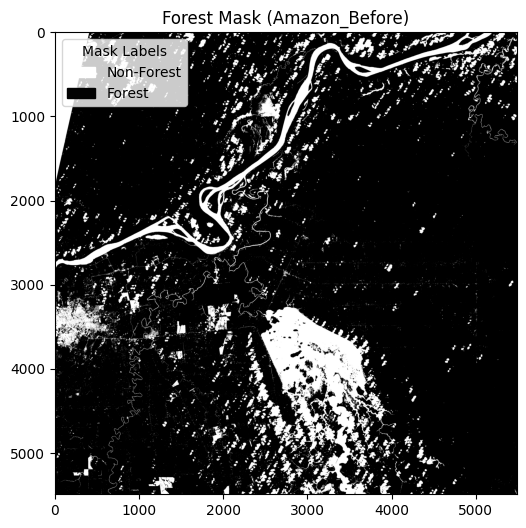

Processing Amazon_After...


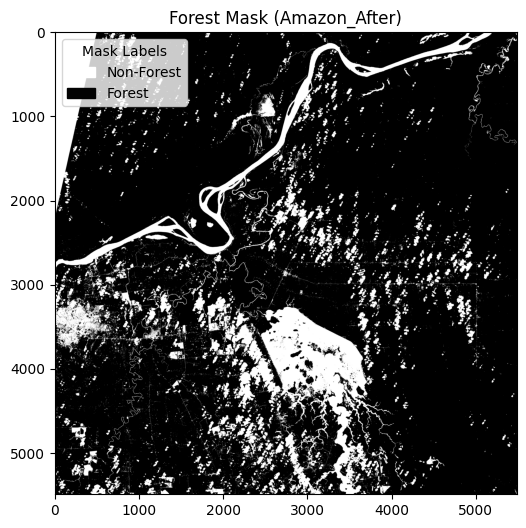

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Paths ---
unzipped_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products"
folder_names = ["Amazon_Before", "Amazon_After"]

# --- Function to create forest vs non-forest mask from SCL band ---
def create_forest_mask_from_scl(safe_dir):
    # Locate granule directory
    granule_dir = None
    for root, dirs, files in os.walk(os.path.join(safe_dir, "GRANULE")):
        for d in dirs:
            granule_dir = os.path.join(root, d)
            break
        if granule_dir:
            break
    if not granule_dir:
        print(f"Granule not found in {safe_dir}")
        return None

    # Locate SCL band in R20m folder
    img_data_dir = os.path.join(granule_dir, "IMG_DATA", "R20m")
    scl_file = None
    for file in os.listdir(img_data_dir):
        if file.endswith("SCL_20m.jp2"):
            scl_file = os.path.join(img_data_dir, file)
            break
    if not scl_file:
        print(f"SCL_20m.jp2 not found in {img_data_dir}")
        return None

    with rasterio.open(scl_file) as scl_src:
        scl_data = scl_src.read(1)

    # Forest = class 4 (vegetation), Non-Forest = all else
    mask = np.where(scl_data == 4, 1, 0).astype(np.uint8)

    return mask

# --- Visualize forest vs non-forest masks ---
for folder in folder_names:
    safe_path = os.path.join(unzipped_dir, folder)
    print(f"Processing {folder}...")
    forest_mask = create_forest_mask_from_scl(safe_path)
    if forest_mask is not None:
        # Create legend
        patches = [
            Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Non-Forest
            Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Forest
        ]
        labels = ['Non-Forest', 'Forest']
        plt.figure(figsize=(8,6))
        plt.legend(patches, labels, loc='upper left', title='Mask Labels')
        plt.imshow(forest_mask, cmap='binary')
        plt.title(f'Forest Mask ({folder})')
        plt.show()
    else:
        print(f"Forest mask creation failed for {folder}.")


# Sentinel-2 Deforestation Analysis Workflow

Processes Sentinel-2 satellite data to generate and save Normalised Difference Vegetation Index (NDVI) images, false colour composites, forest masks, and a deforestation change mask for two datasets ("Amazon_Before" and "Amazon_After").

- It imports essential libraries: `os` for path handling, `numpy` for numerical operations, `rasterio` for reading geospatial raster data, and `matplotlib.pyplot` for image saving.
- The `save_dir` variable sets the directory where outputs will be saved, ensuring it exists.
- The `paths` dictionary defines explicit paths to the `R20m` image directories for each dataset.
- The `bands` dictionary maps descriptive names to their corresponding Sentinel-2 band file names.
- The `read_band` function reads a specified band from a given directory as a NumPy array.
- The `compute_ndvi` function calculates NDVI, a measure of vegetation health, using the formula `(NIR - Red) / (NIR + Red)`.
- The `compute_false_color` function creates a composite image using SWIR1, NIR, and Blue bands, stacked as RGB.
- The `save_image` function visualises and saves a given NumPy array as an image with custom colormap and scaling.
- The code iterates over each dataset:
  - Reads the Red, NIR, SWIR1, Blue, and SCL bands.
  - Computes NDVI, false colour composites, and forest masks (where SCL class 4 indicates forest).
  - Saves these as `.npy` files (for further processing) and as `.png` images (for visual inspection).
- It then checks if both forest masks are available:
  - Generates a change mask highlighting areas that transitioned from forest to non-forest (deforestation) between "Amazon_Before" and "Amazon_After".
  - Saves the change mask as both `.npy` and `.png` formats.

This processing pipeline produces visual and analytical outputs essential for monitoring deforestation events and understanding changes in vegetation over time.


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
os.makedirs(save_dir, exist_ok=True)

# --- Explicit Paths for Each Dataset ---
paths = {
    'Amazon_Before': "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Amazon_Before/GRANULE/L2A_T20LMR_A025933_20200609T142737/IMG_DATA/R20m",
    'Amazon_After': "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Amazon_After/GRANULE/L2A_T20LMR_A031224_20210614T143039/IMG_DATA/R20m"
}

# --- Bands ---
bands = {
    'Red': 'B04_20m.jp2',
    'NIR': 'B8A_20m.jp2',
    'SWIR1': 'B11_20m.jp2',
    'Blue': 'B02_20m.jp2',
    'SCL': 'SCL_20m.jp2'
}

# --- Helper to read bands ---
def read_band(band_dir, band_name):
    for file in os.listdir(band_dir):
        if band_name in file:
            path = os.path.join(band_dir, file)
            with rasterio.open(path) as src:
                return src.read(1).astype('float32')
    print(f"{band_name} not found in {band_dir}")
    return None

# --- Compute NDVI and False Color ---
def compute_ndvi(red, nir):
    return (nir - red) / (nir + red + 1e-10)

def compute_false_color(swir1, nir, blue):
    return np.stack([swir1, nir, blue], axis=-1)

# --- Save Image ---
def save_image(array, path, cmap='viridis', vmin=None, vmax=None):
    plt.figure(figsize=(8,6))
    plt.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(os.path.basename(path).replace('_', ' ').split('.')[0])
    plt.savefig(path)
    plt.close()

# --- Process Amazon_Before and Amazon_After ---
ndvi_data = {}
false_color_data = {}
forest_masks = {}

for ds, band_dir in paths.items():
    print(f"Processing {ds}...")

    red = read_band(band_dir, bands['Red'])
    nir = read_band(band_dir, bands['NIR'])
    swir1 = read_band(band_dir, bands['SWIR1'])
    blue = read_band(band_dir, bands['Blue'])
    scl = read_band(band_dir, bands['SCL'])

    if any(x is None for x in [red, nir, swir1, blue, scl]):
        print(f"Missing bands for {ds}, skipping.")
        continue

    # NDVI & False Color
    ndvi = compute_ndvi(red, nir)
    false_color = compute_false_color(swir1, nir, blue)
    forest_mask = np.where(scl == 4, 1, 0).astype(np.uint8)

    ndvi_data[ds] = ndvi
    false_color_data[ds] = false_color
    forest_masks[ds] = forest_mask

    # Save numpy arrays
    np.save(os.path.join(save_dir, f"{ds}_ndvi.npy"), ndvi)
    np.save(os.path.join(save_dir, f"{ds}_false_color.npy"), false_color)
    np.save(os.path.join(save_dir, f"{ds}_forest_mask.npy"), forest_mask)

    # Save images
    save_image(ndvi, os.path.join(save_dir, f"{ds}_ndvi.png"), cmap='RdYlGn')
    save_image(forest_mask, os.path.join(save_dir, f"{ds}_forest_mask.png"), cmap='binary', vmin=0, vmax=1)
    print(f"Saved NDVI, False Color, and Forest Mask for {ds}")

# --- Create Change Mask (Deforestation) ---
if 'Amazon_Before' in forest_masks and 'Amazon_After' in forest_masks:
    print("Creating and saving change mask (deforestation)...")
    change_mask = np.where((forest_masks['Amazon_Before'] == 1) & (forest_masks['Amazon_After'] == 0), 1, 0).astype(np.uint8)
    np.save(os.path.join(save_dir, "change_mask.npy"), change_mask)
    save_image(change_mask, os.path.join(save_dir, "change_mask.png"), cmap='binary', vmin=0, vmax=1)
    print("Change mask saved as numpy and PNG.")
else:
    print("Missing forest masks for change mask generation.")


Processing Amazon_Before...
Saved NDVI, False Color, and Forest Mask for Amazon_Before
Processing Amazon_After...
Saved NDVI, False Color, and Forest Mask for Amazon_After
Creating and saving change mask (deforestation)...
Change mask saved as numpy and PNG.


This code visualises and displays saved output images from previous data processing steps, such as NDVI, forest masks, and the change mask, for both 'Amazon_Before' and 'Amazon_After'.

- The `matplotlib.pyplot` library is used for plotting, and `os` is used for file path handling.
- The `save_dir` variable specifies the directory where the output images are saved.
- The `image_files` list contains the filenames of the images to be displayed, including NDVI, forest mask, and change mask images.
- The code iterates over each image filename:
  - Constructs the full path to the image file.
  - Checks if the file exists; if it does, the image is read and displayed using `matplotlib`, with axes turned off for a cleaner view and a title derived from the filename.
  - If the file does not exist, a message is printed indicating the missing file.

This ensures visual confirmation of the output images generated from the data processing pipeline, facilitating review and interpretation of deforestation analysis.


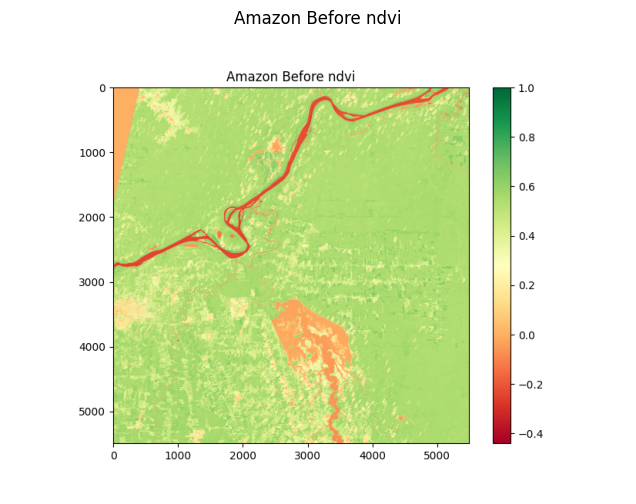

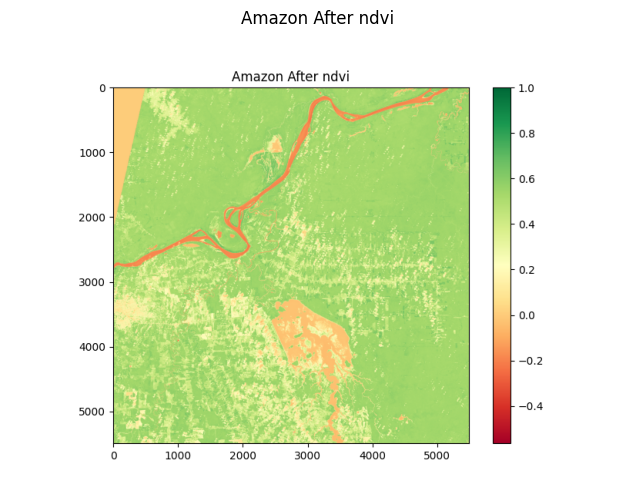

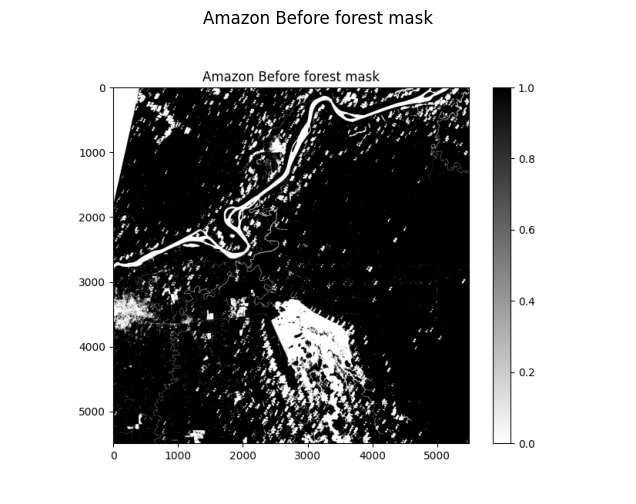

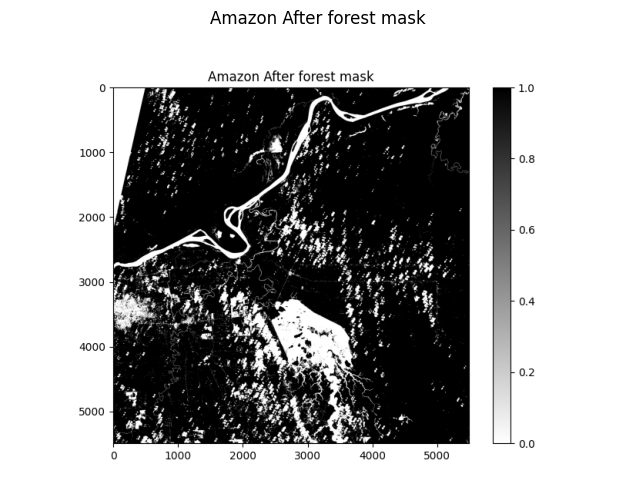

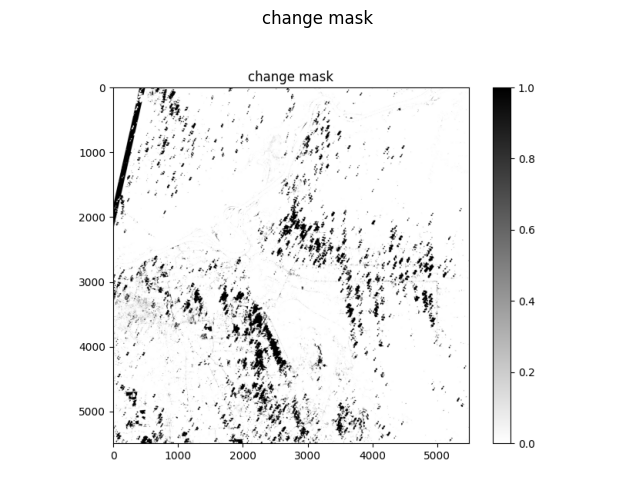

In [ ]:
import matplotlib.pyplot as plt
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
image_files = [
    "Amazon_Before_ndvi.png",
    "Amazon_After_ndvi.png",
    "Amazon_Before_forest_mask.png",
    "Amazon_After_forest_mask.png",
    "change_mask.png"
]

# --- Display Images ---
for img_file in image_files:
    img_path = os.path.join(save_dir, img_file)
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file.replace('_', ' ').split('.')[0])
        plt.show()
    else:
        print(f"Image {img_file} not found in {save_dir}")


# Making and Training the models

This code prepares input and label data arrays for training a Convolutional Neural Network (CNN) to detect deforestation using NDVI measurements.

- It imports `numpy` for numerical operations and `os` for handling file paths.
- The `save_dir` variable specifies the directory where the processed data is stored.
- NDVI data for 'Amazon_Before' and 'Amazon_After' and the change mask are loaded from `.npy` files.
- An optional commented-out section is included for using false colour composites (multi-channel) as an alternative to NDVI for input data.
- By default, the code uses NDVI data (single-channel) and:
  - Expands the dimensions of both before and after NDVI arrays to (height, width, 1) for compatibility.
  - Concatenates these arrays along the last axis to form a two-channel input representing pre- and post-deforestation NDVI values.
- The `label_data` is set as the `change_mask`, which serves as the ground truth for training.
- Both the concatenated `input_data` and the `label_data` are saved as `.npy` files, ready to be used as inputs and labels during CNN model training.
- The shapes of the input and label data arrays are printed to confirm successful preparation.

This step finalises the data preparation phase, setting up structured arrays that can be used to train a CNN model for detecting changes in forest cover over time.


In [ ]:
import numpy as np
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"

# --- Load Data ---
before_ndvi = np.load(os.path.join(save_dir, "Amazon_Before_ndvi.npy"))
after_ndvi = np.load(os.path.join(save_dir, "Amazon_After_ndvi.npy"))
change_mask = np.load(os.path.join(save_dir, "change_mask.npy"))

# --- Option: Use False Color (multi-channel) instead of NDVI ---
# before_fc = np.load(os.path.join(save_dir, "Amazon_Before_false_color.npy"))
# after_fc = np.load(os.path.join(save_dir, "Amazon_After_false_color.npy"))
# input_data = np.concatenate([before_fc, after_fc], axis=-1)

# --- Use NDVI (single-channel) ---
# Expand dimensions to (height, width, 1) for consistency
before_ndvi_exp = np.expand_dims(before_ndvi, axis=-1)
after_ndvi_exp = np.expand_dims(after_ndvi, axis=-1)
input_data = np.concatenate([before_ndvi_exp, after_ndvi_exp], axis=-1)  # Shape: (H, W, 2)

# --- Labels ---
label_data = change_mask  # Shape: (H, W)

# --- Save for CNN Training ---
np.save(os.path.join(save_dir, "cnn_input_data.npy"), input_data)
np.save(os.path.join(save_dir, "cnn_label_data.npy"), label_data)

print(f"Training input data shape: {input_data.shape}")
print(f"Label data shape: {label_data.shape}")


Training input data shape: (5490, 5490, 2)
Label data shape: (5490, 5490)


This code defines and builds a Convolutional Neural Network (CNN) model using TensorFlow and Keras, designed for binary classification of changes in forest cover (e.g., deforestation) based on input data with two channels (e.g., NDVI before and after).

- The `tensorflow` library is imported, along with Keras layers and model-building components.
- The `build_cnn` function constructs a CNN with an encoder-decoder architecture:
  - **Input Layer**: Accepts input data with shape `(None, None, 2)`, representing variable-sized images with two channels (e.g., NDVI before and after).
  - **Encoder**: Consists of two blocks of two convolutional layers each (32 filters for the first block, 64 for the second), followed by max pooling to reduce spatial dimensions.
  - **Bottleneck**: Contains two convolutional layers with 128 filters, capturing deeper features from the encoded data.
  - **Decoder**: Includes two upsampling layers, each followed by concatenation with corresponding encoder features (skip connections), and two convolutional layers (64 and 32 filters, respectively) to reconstruct the spatial details.
  - **Output Layer**: A 1x1 convolution with sigmoid activation produces a single-channel binary output map, where pixel values indicate deforestation likelihood.
- The model is compiled using the Adam optimiser, binary cross-entropy loss (suitable for binary classification tasks), and accuracy as the performance metric.
- Finally, the CNN model is instantiated and summarised, displaying its architecture, including layer types, output shapes, and parameter counts.

This CNN architecture enables the detection of spatial changes (such as deforestation) from paired input data (e.g., pre- and post-event NDVI images).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(None, None, 2)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D((2,2))(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2,2))(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c4)

    # Output
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# --- Build and summarize ---
cnn_model = build_cnn()
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 2)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        608 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,248 │ conv2d[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,496 │ max_pooling2d[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_2[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     73,856 │ max_pooling2d_1[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_4[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, None,      │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ None, 192)        │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │    110,656 │ concatenate[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_6[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, None,      │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None,      │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ None, 96)         │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │     27,680 │ concatenate_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │      9,248 │ conv2d_8[0][0]  

 Total params: 471,265 (1.80 MB)

 Trainable params: 471,265 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

This code prepares training and validation data, trains a Convolutional Neural Network (CNN) model on satellite image patches for deforestation detection, and saves the trained model.

- It imports necessary libraries: `numpy` for numerical processing, `train_test_split` from `scikit-learn` for splitting data into training and validation sets, and `tensorflow` for deep learning.
- The `save_dir` variable specifies the directory containing preprocessed input and label data.
- Input and label data are loaded from `.npy` files:
  - `input_data` contains paired NDVI images (before and after deforestation) as input.
  - `label_data` contains corresponding binary masks indicating areas of deforestation.
- Label data is reshaped to match the CNN output by adding a singleton channel dimension.
- Input data is normalised to the range [0, 1], replacing any NaN values.
- Instead of random splits at the pixel level, the code extracts patches of size `patch_size x patch_size` (default 64x64) from the full images using the `extract_patches` function.
  - This ensures local spatial context is preserved in training.
  - The total number of extracted patches is printed.
- The extracted patches are then split into training and validation sets (80% training, 20% validation) with reproducibility ensured via a random seed.
- The CNN model is loaded (built using the previously defined `build_cnn` function) with an input shape matching the patch size and number of channels.
- The model is trained for 10 epochs (this can be adjusted) using a batch size of 16.
- Training history is saved for future analysis of performance metrics.
- Finally, the trained model is saved to disk in HDF5 format (`.h5`) for later use in inference or deployment.

This completes the end-to-end workflow from data preparation and patch extraction to training a CNN model for detecting deforestation from satellite imagery.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
input_data = np.load(os.path.join(save_dir, "cnn_input_data.npy"))
label_data = np.load(os.path.join(save_dir, "cnn_label_data.npy"))

# --- Preprocess ---
# Expand label data to match CNN output shape
label_data = np.expand_dims(label_data, axis=-1)  # Shape: (H, W, 1)

# Normalize input data (if not already scaled)
input_data = np.nan_to_num(input_data)  # Replace NaNs (if any)
input_data = (input_data - np.min(input_data)) / (np.max(input_data) - np.min(input_data))

# Split into training and validation (e.g., 80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    input_data.reshape(-1, input_data.shape[2]),
    label_data.reshape(-1, 1),
    test_size=0.2, random_state=42
)

# Reshape to (samples, height, width, channels)
patch_size = 64  # or 128 for larger patches
def extract_patches(X, y, patch_size):
    H, W, C = input_data.shape
    patches_X, patches_y = [], []
    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            patch_X = input_data[i:i+patch_size, j:j+patch_size, :]
            patch_y = label_data[i:i+patch_size, j:j+patch_size, :]
            patches_X.append(patch_X)
            patches_y.append(patch_y)
    return np.array(patches_X), np.array(patches_y)

X_patches, y_patches = extract_patches(input_data, label_data, patch_size)
print(f"Extracted {len(X_patches)} patches of size {patch_size}x{patch_size}")

# Split patches into train/val
X_train, X_val, y_train, y_val = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)

# --- Load CNN Model ---
cnn_model = build_cnn(input_shape=(patch_size, patch_size, input_data.shape[2]))

# --- Train ---
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Increase epochs as needed
    batch_size=16
)

# --- Save Model ---
model_path = os.path.join(save_dir, "cnn_deforestation_model.h5")
cnn_model.save(model_path)
print(f"Model saved at {model_path}")


Extracted 7225 patches of size 64x64
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_18']
Received: inputs=Tensor(shape=(None, 64, 64, 2))
  warnings.warn(msg)


362/362 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.9421 - loss: 0.1838 - val_accuracy: 0.9692 - val_loss: 0.0814
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.9670 - loss: 0.0876 - val_accuracy: 0.9698 - val_loss: 0.0796
Epoch 3/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.9696 - loss: 0.0811 - val_accuracy: 0.9719 - val_loss: 0.0706
Epoch 4/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.9729 - loss: 0.0684 - val_accuracy: 0.9740 - val_loss: 0.0665
Epoch 5/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9731 - loss: 0.0675 - val_accuracy: 0.9757 - val_loss: 0.0601
Epoch 6/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.9750 - loss: 0.0621 - val_accuracy: 0.9766 - val_loss: 0.0573
Epoch 7/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.9750 - loss: 0.0615 - val_accuracy: 0.9737 - val_loss: 0.0657
Epoch 8/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.9766 - loss: 0.0580 - val_accuracy: 0.977

Model saved at /content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data/cnn_deforestation_model.h5


This code applies unsupervised K-means clustering to the difference between 'before' and 'after' NDVI (Normalised Difference Vegetation Index) data to identify areas of potential deforestation, and visualises the results.

- It imports `numpy` for numerical processing, `KMeans` from `scikit-learn` for clustering, `matplotlib.pyplot` for plotting, and `os` for file path handling.
- The `save_dir` variable specifies the directory where data is stored and output files will be saved.
- NDVI data for 'Amazon_Before' and 'Amazon_After' is loaded from `.npy` files.
- The difference between the two NDVI datasets is calculated and flattened into a 1D array suitable for clustering.
- K-means clustering is applied with two clusters (n=2) to classify pixels into categories based on NDVI change, effectively separating areas of significant change from those of minimal change.
- The resulting cluster labels are reshaped to match the original NDVI dimensions, allowing spatial visualisation.
- The cluster results are visualised:
  - A single plot shows the clustering result with a colour bar.
  - An optional side-by-side comparison with the ground truth `change_mask` highlights how well the clustering approximates true deforestation changes.
- The cluster labels are saved as a `.npy` file for further analysis or validation.
- A message confirms successful completion and saving of the clustering output.

This approach enables an unsupervised method for identifying regions of NDVI change, potentially corresponding to deforestation, complementing the supervised CNN approach used earlier.


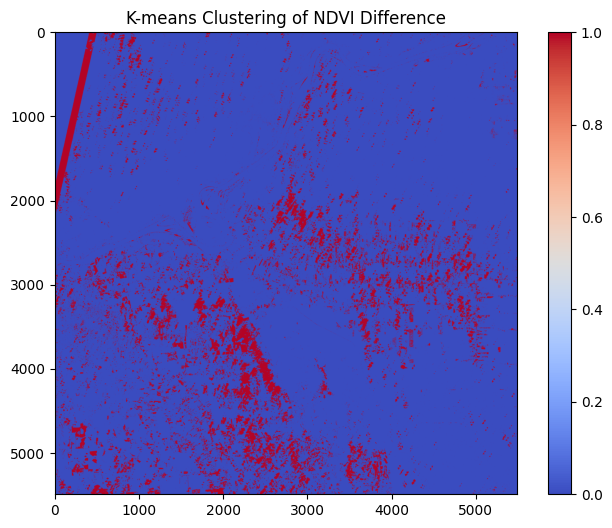

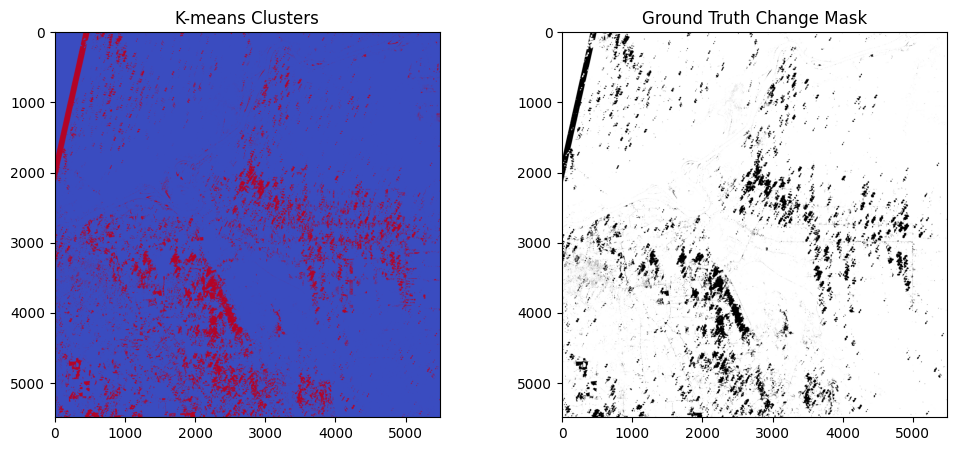

K-means clustering completed and saved.


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"

# --- Load NDVI ---
before_ndvi = np.load(os.path.join(save_dir, "Amazon_Before_ndvi.npy"))
after_ndvi = np.load(os.path.join(save_dir, "Amazon_After_ndvi.npy"))

# --- Compute NDVI Difference ---
ndvi_diff = after_ndvi - before_ndvi
ndvi_diff_flat = ndvi_diff.flatten().reshape(-1, 1)

# --- Apply K-means Clustering (2 clusters) ---
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(ndvi_diff_flat)
cluster_labels = kmeans.labels_.reshape(ndvi_diff.shape)

# --- Visualize Clusters ---
plt.figure(figsize=(8,6))
plt.imshow(cluster_labels, cmap='coolwarm')
plt.colorbar()
plt.title("K-means Clustering of NDVI Difference")
plt.savefig(os.path.join(save_dir, "kmeans_clusters.png"))
plt.show()

# --- Optional: Compare with Change Mask ---
change_mask = np.load(os.path.join(save_dir, "change_mask.npy"))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cluster_labels, cmap='coolwarm')
plt.title("K-means Clusters")
plt.subplot(1,2,2)
plt.imshow(change_mask, cmap='binary')
plt.title("Ground Truth Change Mask")
plt.show()

# --- Save Cluster Labels ---
np.save(os.path.join(save_dir, "kmeans_clusters.npy"), cluster_labels)
print("K-means clustering completed and saved.")


This code extracts overlapping patches from the prepared NDVI input data and change mask label data, and saves these patches for use in training or validation of the CNN model.

- It imports `numpy` for numerical operations and `os` for file handling.
- The `save_dir` variable points to the directory containing the full input and label data arrays, while `patch_save_dir` specifies the directory where extracted patches will be saved. This directory is created if it does not already exist.
- Input data (`cnn_input_data.npy`) is a stack of pre- and post-event NDVI images with shape (height, width, 2), and label data (`cnn_label_data.npy`) is the corresponding change mask.
- The `label_data` is expanded to have a singleton channel dimension for consistency with the CNN model output shape.
- A patch size of 64x64 pixels is chosen, with a stride of 32 pixels to allow overlapping patches and increase the volume of training data.
- The code iterates over the input image dimensions, extracting patches of the specified size from both input and label data.
  - It checks that each extracted patch matches the desired dimensions to ensure uniformity.
  - Extracted patches are appended to separate lists for inputs (`patches_X`) and labels (`patches_Y`).
- The extracted patches are converted into NumPy arrays and the total number of patches is printed.
- These patches are then saved as `.npy` files (`X_spatial.npy` and `Y_spatial.npy`) for future training or validation of the CNN model.

This patch extraction process is crucial for training CNN models on high-resolution imagery, enabling efficient learning of local features and patterns associated with deforestation.


In [ ]:
import numpy as np
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")
os.makedirs(patch_save_dir, exist_ok=True)

# --- Load Data ---
input_data = np.load(os.path.join(save_dir, "cnn_input_data.npy"))  # NDVI stack (H, W, 2)
label_data = np.load(os.path.join(save_dir, "cnn_label_data.npy"))  # Change mask (H, W)

# Expand label_data to (H, W, 1)
label_data = np.expand_dims(label_data, axis=-1)

# --- Extract Patches ---
patch_size = 64
stride = 32  # Overlapping patches for more data
patches_X, patches_Y = [], []

H, W = input_data.shape[:2]
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch_X = input_data[i:i+patch_size, j:j+patch_size, :]
        patch_Y = label_data[i:i+patch_size, j:j+patch_size, :]
        if patch_X.shape[:2] == (patch_size, patch_size):
            patches_X.append(patch_X)
            patches_Y.append(patch_Y)

patches_X = np.array(patches_X)
patches_Y = np.array(patches_Y)
print(f"Extracted {len(patches_X)} patches of size {patch_size}x{patch_size}")

# Save patches
np.save(os.path.join(patch_save_dir, "X_spatial.npy"), patches_X)
np.save(os.path.join(patch_save_dir, "Y_spatial.npy"), patches_Y)


Extracted 28900 patches of size 64x64


This code loads the previously extracted spatial patches and trains a CNN model specifically on these patches to detect deforestation, saving the trained model upon completion.

- It imports `load_model` from `tensorflow.keras.models` to handle CNN models, and `train_test_split` from `scikit-learn` to split data into training and validation sets.
- Extracted patches (`X_spatial.npy` and `Y_spatial.npy`) are loaded from the patch directory. These contain input NDVI patches and corresponding change mask labels.
- The data is split into training and validation sets with an 80/20 ratio, using a fixed random seed for reproducibility.
- The `build_cnn` function is used to construct a CNN model with an input shape matching the patch dimensions and number of channels (2, representing pre- and post-deforestation NDVI).
- The model is trained on the extracted patches for 10 epochs using a batch size of 16, with validation performance monitored during training.
- Upon completion, the trained model is saved to disk as `cnn_model_spatial.h5`.
- A message is printed to confirm that the spatial CNN model has been saved.

This process enables the CNN to learn spatial patterns of deforestation from localised NDVI patches, improving its ability to detect changes in unseen data.


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# Load patches
X_spatial = np.load(os.path.join(patch_save_dir, "X_spatial.npy"))
Y_spatial = np.load(os.path.join(patch_save_dir, "Y_spatial.npy"))

# Train/Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(X_spatial, Y_spatial, test_size=0.2, random_state=42)

# Load CNN architecture
cnn_model_spatial = build_cnn(input_shape=(patch_size, patch_size, 2))

# Train
history = cnn_model_spatial.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=16
)

# Save model
cnn_model_spatial.save(os.path.join(save_dir, "cnn_model_spatial.h5"))
print("Spatial CNN model saved.")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(16, 64, 64, 2))
  warnings.warn(msg)


1445/1445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9660 - loss: 0.0984

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(None, 64, 64, 2))
  warnings.warn(msg)


1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2177s 2s/step - accuracy: 0.9660 - loss: 0.0984 - val_accuracy: 0.9752 - val_loss: 0.0635
Epoch 2/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2183s 2s/step - accuracy: 0.9763 - loss: 0.0587 - val_accuracy: 0.9781 - val_loss: 0.0541
Epoch 3/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2233s 2s/step - accuracy: 0.9796 - loss: 0.0500 - val_accuracy: 0.9801 - val_loss: 0.0481
Epoch 4/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2172s 2s/step - accuracy: 0.9814 - loss: 0.0456 - val_accuracy: 0.9822 - val_loss: 0.0464
Epoch 5/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2191s 2s/step - accuracy: 0.9829 - loss: 0.0421 - val_accuracy: 0.9844 - val_loss: 0.0390
Epoch 6/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2155s 1s/step - accuracy: 0.9843 - loss: 0.0389 - val_accuracy: 0.9840 - val_loss: 0.0401
Epoch 7/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2212s 2s/step - accuracy: 0.9853 - loss: 0.0364 - val_accuracy: 0.9857 - val_loss: 0.0356
Epoch 8/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 2208s 1s/step - accuracy: 0.9869 - loss: 0.03

Spatial CNN model saved.


This code extracts patches from the computed NDVI difference image, flattens them for use in clustering or other machine learning tasks, and provides a count of the extracted patches.

- It imports `numpy` for numerical operations and `os` for handling file paths.
- The `save_dir` variable specifies the directory containing preprocessed data, while `patch_save_dir` points to the directory designated for saving extracted patches.
- NDVI images for 'Amazon_Before' and 'Amazon_After' are loaded from `.npy` files.
- The difference between these NDVI images is calculated to highlight changes over time.
- The code extracts patches of size 64x64 pixels from the NDVI difference image, with a stride of 32 pixels to allow overlapping patches and increase the data volume.
- Each extracted patch is flattened into a 1D array, making it suitable for clustering methods such as K-means or other machine learning algorithms that require vectorised input.
- The total number of extracted patches is printed to provide a quick summary of the dataset size.

This step is essential for preparing NDVI difference data in a format ready for unsupervised learning or classification analysis.


In [ ]:
import numpy as np
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")

# Load NDVI Before & After
before_ndvi = np.load(os.path.join(save_dir, "Amazon_Before_ndvi.npy"))
after_ndvi = np.load(os.path.join(save_dir, "Amazon_After_ndvi.npy"))

# Compute NDVI Difference
ndvi_diff = after_ndvi - before_ndvi

# Extract NDVI Difference Patches
patch_size = 64
stride = 32
patches_diff = []

H, W = ndvi_diff.shape
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch = ndvi_diff[i:i+patch_size, j:j+patch_size]
        if patch.shape == (patch_size, patch_size):
            patches_diff.append(patch.flatten())  # Flatten for clustering

patches_diff = np.array(patches_diff)
print(f"Extracted {len(patches_diff)} NDVI difference patches.")


Extracted 28900 NDVI difference patches.


This code applies K-means clustering to NDVI difference patches, reshapes the cluster assignments into a spatial grid, visualises the result, and saves the clustering output.

- The `KMeans` class from `scikit-learn` is used for clustering the extracted NDVI difference patches into two clusters (n=2).
- The `kmeans.fit()` method fits the model to the flattened NDVI difference patches (`patches_diff`), generating cluster labels for each patch.
- The number of patches in each dimension (x and y) is calculated based on the image size, patch size, and stride.
- The 1D cluster labels are reshaped into a 2D grid (`cluster_grid`) matching the spatial layout of the extracted patches, allowing a visual representation of clustered regions in the image.
- A colour-coded plot (`coolwarm` colormap) is generated to display the spatial distribution of clusters, aiding in visual interpretation of the NDVI difference patterns.
- The cluster grid is saved as a `.npy` file for future reference or comparison.
- A message confirms that the spatial K-means clustering result has been saved.

This step enables a spatially coherent visualisation of NDVI difference-based clustering, complementing supervised learning models and highlighting areas of significant environmental change.


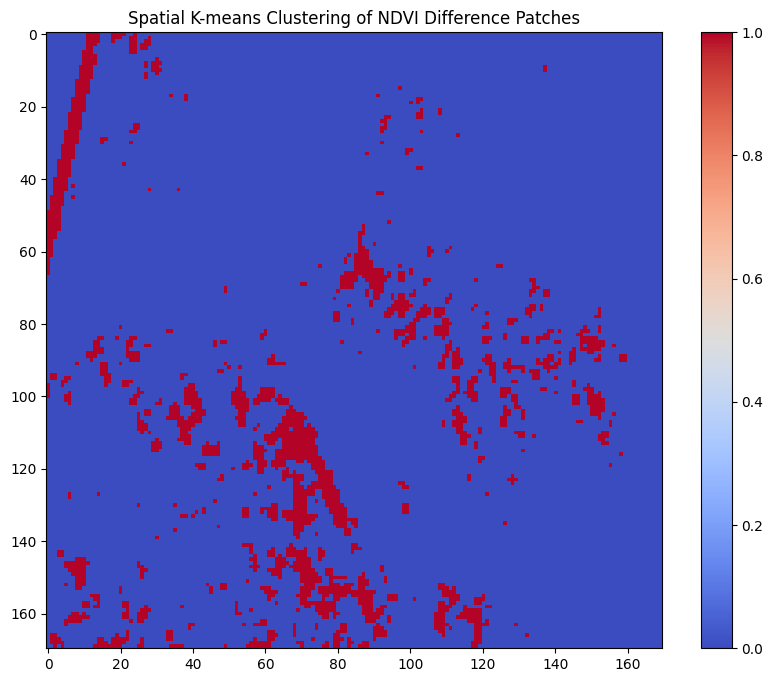

Spatial K-means clustering saved.


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-means (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(patches_diff)
cluster_labels = kmeans.labels_

# Reshape to spatial grid
num_patches_x = (W - patch_size) // stride + 1
num_patches_y = (H - patch_size) // stride + 1
cluster_grid = cluster_labels.reshape(num_patches_y, num_patches_x)

# Visualize Cluster Grid
plt.figure(figsize=(10,8))
plt.imshow(cluster_grid, cmap='coolwarm')
plt.title("Spatial K-means Clustering of NDVI Difference Patches")
plt.colorbar()
plt.show()

# Save Cluster Grid
np.save(os.path.join(patch_save_dir, "kmeans_clusters_spatial.npy"), cluster_grid)
print("Spatial K-means clustering saved.")


This code loads a trained CNN model, applies it to the entire input data by splitting the image into patches, predicts deforestation, reconstructs the full prediction tile, and saves the resulting binary prediction map.

- The `tensorflow.keras.models.load_model` function is used to load the trained CNN model from a `.h5` file.
- The input data is loaded from `cnn_input_data.npy`, and the dimensions of the full image (height `H` and width `W`) are determined.
- Patches of size 64x64 pixels are extracted from the full input data without overlap (stride = patch size) for the pixel-wise CNN prediction.
- Each patch is stored along with its top-left position `(i, j)` in the original image for later reconstruction.
- The model predicts deforestation probabilities for each patch, and the outputs are thresholded at 0.5 to obtain binary predictions.
- To reconstruct the full prediction image:
  - A zero-initialised array `reconstructed` accumulates predicted patch values.
  - A `weight` array tracks the number of times each pixel is covered by patches to account for overlapping areas.
  - The reconstructed predictions are averaged over overlaps and thresholded at 0.5 to obtain a binary prediction map (`cnn_pixel_pred`).
- The final reconstructed prediction is saved as a `.npy` file for later use or visualisation.
- A message confirms the saving of the CNN pixel prediction results.

This method enables pixel-level predictions of deforestation over the entire satellite image, leveraging a trained CNN and systematic patch extraction and reconstruction.


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
model_path_pixel = os.path.join(save_dir, "cnn_deforestation_model.h5")

# Load model and input data
model_pixel = load_model(model_path_pixel)
input_data = np.load(os.path.join(save_dir, "cnn_input_data.npy"))
H, W = input_data.shape[:2]
patch_size = 64
stride = 64  # No overlap for pixel CNN

# Extract patches from full input
patches_X = []
positions = []
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch_X = input_data[i:i+patch_size, j:j+patch_size, :]
        if patch_X.shape[:2] == (patch_size, patch_size):
            patches_X.append(patch_X)
            positions.append((i, j))
patches_X = np.array(patches_X)

# Predict
pred_patches = model_pixel.predict(patches_X)
pred_patches_binary = (pred_patches > 0.5).astype(np.uint8)

# Reconstruct full prediction tile
reconstructed = np.zeros((H, W, 1))
weight = np.zeros((H, W, 1))
for (i, j), patch_pred in zip(positions, pred_patches_binary):
    reconstructed[i:i+patch_size, j:j+patch_size, :] += patch_pred
    weight[i:i+patch_size, j:j+patch_size, :] += 1

# Average overlapping patches
reconstructed = reconstructed / np.maximum(weight, 1)
cnn_pixel_pred = (reconstructed[..., 0] > 0.5).astype(np.uint8)

# Save predictions
np.save(os.path.join(save_dir, "cnn_pixel_predictions.npy"), cnn_pixel_pred)
print("CNN Pixel predictions saved.")


226/226 ━━━━━━━━━━━━━━━━━━━━ 162s 712ms/step
CNN Pixel predictions saved.


This code loads a trained CNN model, applies it to the entire input data by extracting overlapping patches, predicts deforestation, reconstructs the full prediction map, and saves the resulting binary prediction.

- The `tensorflow.keras.models.load_model` function loads the trained spatial CNN model from a `.h5` file.
- The `input_data` is loaded from `cnn_input_data.npy`, representing the paired NDVI (before and after) for the full scene.
- The dimensions of the input data are used to determine how many patches to extract.
- Patches of size 64x64 pixels are extracted from the full input data with a stride of 32 pixels, allowing for overlapping patches and producing smoother predictions.
- Each patch’s top-left position `(i, j)` is recorded for later reconstruction.
- The model predicts the likelihood of deforestation for each patch, thresholding predictions at 0.5 to create binary maps.
- The reconstruction of the full prediction involves:
  - Summing the predicted values at each pixel position, accommodating overlapping patches.
  - Dividing by the number of overlapping patches (using a weight matrix) to compute an average value for each pixel.
  - Thresholding the averaged values at 0.5 to obtain a final binary deforestation prediction (`cnn_spatial_pred`).
- The binary prediction is saved as a `.npy` file for further analysis or visualisation.
- A message confirms the saving of the CNN spatial prediction results.

This approach leverages overlapping patches and averaging to produce a smoother, more accurate full-scene prediction of deforestation patterns.


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import os

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")
model_path_spatial = os.path.join(save_dir, "cnn_model_spatial.h5")

# Load model and input data
model_spatial = load_model(model_path_spatial)
input_data = np.load(os.path.join(save_dir, "cnn_input_data.npy"))
H, W = input_data.shape[:2]
patch_size = 64
stride = 32  # Overlapping for smoother predictions

# Extract patches from full input
patches_X = []
positions = []
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch_X = input_data[i:i+patch_size, j:j+patch_size, :]
        if patch_X.shape[:2] == (patch_size, patch_size):
            patches_X.append(patch_X)
            positions.append((i, j))
patches_X = np.array(patches_X)

# Predict
pred_patches = model_spatial.predict(patches_X)
pred_patches_binary = (pred_patches > 0.5).astype(np.uint8)

# Reconstruct full prediction tile
reconstructed = np.zeros((H, W, 1))
weight = np.zeros((H, W, 1))
for (i, j), patch_pred in zip(positions, pred_patches_binary):
    reconstructed[i:i+patch_size, j:j+patch_size, :] += patch_pred
    weight[i:i+patch_size, j:j+patch_size, :] += 1

# Average overlapping patches
reconstructed = reconstructed / np.maximum(weight, 1)
cnn_spatial_pred = (reconstructed[..., 0] > 0.5).astype(np.uint8)

# Save predictions
np.save(os.path.join(save_dir, "cnn_spatial_predictions.npy"), cnn_spatial_pred)
print("CNN Spatial predictions saved.")


904/904 ━━━━━━━━━━━━━━━━━━━━ 555s 614ms/step
CNN Spatial predictions saved.


This code applies K-means clustering directly to the flattened NDVI difference data at the pixel level, saves the resulting clustering, and visualises the result.

- The `KMeans` algorithm from `scikit-learn` is used to classify pixels into two clusters (n=2) based on the difference between 'Amazon_After' and 'Amazon_Before' NDVI values.
- The NDVI difference is computed and flattened into a one-dimensional array with one feature per pixel, reshaped to suit the clustering algorithm.
- The clustering is fitted to the NDVI difference data, generating a label for each pixel indicating its cluster membership.
- The cluster labels are reshaped to match the original NDVI dimensions for visualisation and analysis.
- The cluster labels are saved as a `.npy` file for further processing or comparison.
- A visualisation is generated using `matplotlib`, where the clusters are colour-coded and displayed with a colour bar for easy interpretation.
- The visualised clustering result is saved as a PNG image.
- A message confirms that the pixel-level K-means clustering has been completed and saved.

This pixel-based clustering approach identifies patterns of NDVI change across the entire scene, complementing other methods such as CNN-based predictions or patch-based K-means clustering.


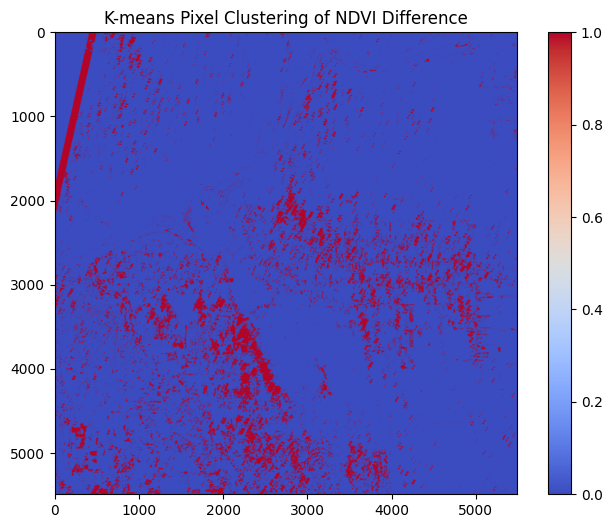

K-means Pixel clustering saved.


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"

# Load NDVI Before & After
before_ndvi = np.load(os.path.join(save_dir, "Amazon_Before_ndvi.npy"))
after_ndvi = np.load(os.path.join(save_dir, "Amazon_After_ndvi.npy"))

# Compute NDVI Difference (Flatten)
ndvi_diff = (after_ndvi - before_ndvi).flatten().reshape(-1,1)

# Apply K-means (2 clusters)
kmeans_pixel = KMeans(n_clusters=2, random_state=42)
kmeans_pixel.fit(ndvi_diff)
kmeans_pixel_labels = kmeans_pixel.labels_.reshape(after_ndvi.shape)

# Save Cluster Labels
np.save(os.path.join(save_dir, "kmeans_clusters_pixel.npy"), kmeans_pixel_labels)

# Visualize
plt.figure(figsize=(8,6))
plt.imshow(kmeans_pixel_labels, cmap='coolwarm')
plt.title("K-means Pixel Clustering of NDVI Difference")
plt.colorbar()
plt.savefig(os.path.join(save_dir, "kmeans_pixel_clusters.png"))
plt.show()

print("K-means Pixel clustering saved.")


This code applies K-means clustering both at the pixel level and the spatial patch level to identify NDVI difference patterns, saving and visualising the results for each.

- **Pixel-Level Clustering**:
  - Computes the difference between 'Amazon_After' and 'Amazon_Before' NDVI values and flattens the result for K-means clustering.
  - Applies K-means with two clusters (n=2) to classify individual pixels based on NDVI change.
  - Reshapes the cluster labels to the original NDVI image dimensions.
  - Saves the pixel-level cluster labels as a `.npy` file and generates a colour-coded visualisation, saved as a PNG image.
  - Provides a quick and straightforward clustering approach based solely on pixel-level NDVI changes.

- **Spatial-Level Clustering**:
  - Divides the NDVI difference image into overlapping patches (64x64 pixels, stride 32) to incorporate local spatial context.
  - Flattens each patch into a 1D feature vector for clustering.
  - Applies K-means with two clusters to classify each patch based on its NDVI difference pattern.
  - Reshapes the resulting cluster labels into a 2D grid that reflects the spatial layout of patches.
  - Saves the spatial-level cluster labels as a `.npy` file and generates a visualisation showing the spatial distribution of clusters.
  - Offers a more structured clustering that captures localised patterns and context.

- Both clustering outputs are saved and displayed, allowing comparison of pixel-based and patch-based clustering methods for understanding deforestation patterns.

This dual approach provides insights at different levels of granularity—pixel precision and local spatial coherence—enhancing the interpretation of NDVI change data.


Generating K-means Pixel Clustering...


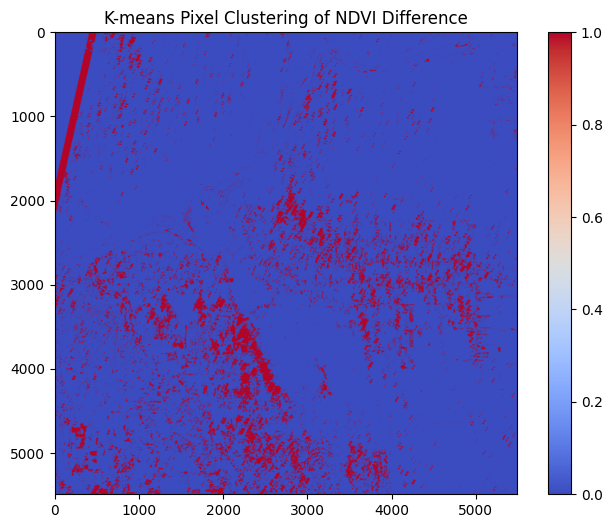

Generating K-means Spatial Clustering...


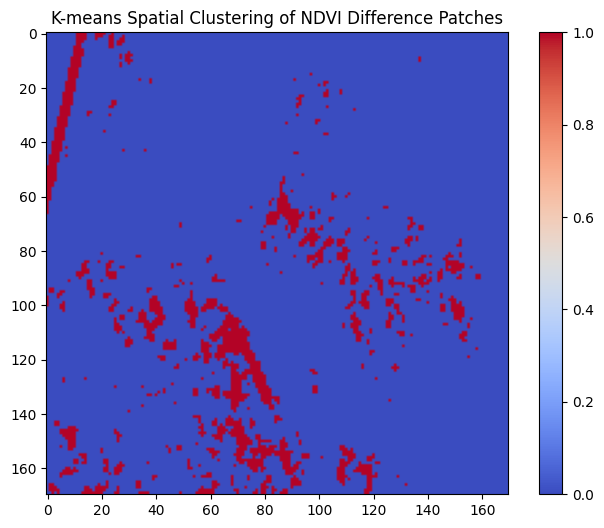

K-means Pixel and Spatial clustering saved.


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")

# Load NDVI Before & After
before_ndvi = np.load(os.path.join(save_dir, "Amazon_Before_ndvi.npy"))
after_ndvi = np.load(os.path.join(save_dir, "Amazon_After_ndvi.npy"))

# --- Pixel-Level K-means ---
print("Generating K-means Pixel Clustering...")
ndvi_diff_pixel = (after_ndvi - before_ndvi).flatten().reshape(-1,1)
kmeans_pixel = KMeans(n_clusters=2, random_state=42)
kmeans_pixel.fit(ndvi_diff_pixel)
kmeans_pixel_labels = kmeans_pixel.labels_.reshape(after_ndvi.shape)
np.save(os.path.join(save_dir, "kmeans_clusters_pixel.npy"), kmeans_pixel_labels)
plt.figure(figsize=(8,6))
plt.imshow(kmeans_pixel_labels, cmap='coolwarm')
plt.title("K-means Pixel Clustering of NDVI Difference")
plt.colorbar()
plt.savefig(os.path.join(save_dir, "kmeans_pixel_clusters.png"))
plt.show()

# --- Spatial-Level K-means ---
print("Generating K-means Spatial Clustering...")
# Extract patches from NDVI difference
patch_size = 64
stride = 32
ndvi_diff = after_ndvi - before_ndvi
H, W = ndvi_diff.shape
patches_diff = []
positions = []
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch = ndvi_diff[i:i+patch_size, j:j+patch_size]
        if patch.shape == (patch_size, patch_size):
            patches_diff.append(patch.flatten())
            positions.append((i,j))
patches_diff = np.array(patches_diff)

# Apply K-means
kmeans_spatial = KMeans(n_clusters=2, random_state=42)
kmeans_spatial.fit(patches_diff)
cluster_labels_spatial = kmeans_spatial.labels_

# Reconstruct spatial grid
num_patches_x = (W - patch_size) // stride + 1
num_patches_y = (H - patch_size) // stride + 1
cluster_grid_spatial = cluster_labels_spatial.reshape(num_patches_y, num_patches_x)

# Save
np.save(os.path.join(patch_save_dir, "kmeans_clusters_spatial.npy"), cluster_grid_spatial)
plt.figure(figsize=(8,6))
plt.imshow(cluster_grid_spatial, cmap='coolwarm')
plt.title("K-means Spatial Clustering of NDVI Difference Patches")
plt.colorbar()
plt.savefig(os.path.join(save_dir, "kmeans_spatial_clusters.png"))
plt.show()

print("K-means Pixel and Spatial clustering saved.")


# Testing the models

This code evaluates and compares the performance of different deforestation detection models (CNN Pixel, CNN Spatial, K-means Pixel, and K-means Spatial) against the ground truth change mask, and visualises the predictions.

- **Loading Data**:  
  - The ground truth change mask and model predictions (CNN pixel, CNN spatial, K-means pixel, and K-means spatial) are loaded from saved `.npy` files.
  - The K-means spatial predictions are expanded from a patch grid to full resolution by averaging overlapping patch predictions, ensuring a direct comparison with the ground truth.
  
- **Cluster Binarisation**:  
  - The `map_clusters` function determines which K-means cluster corresponds to deforestation by comparing cluster assignments with the ground truth and selecting the most accurate mapping.
  
- **Evaluation**:  
  - The `evaluate_model` function computes key performance metrics: Accuracy, Precision, Recall, F1 Score, and Intersection-over-Union (IoU) for each model.
  - Each model’s performance is printed to the console, providing a comprehensive summary of their effectiveness.
  
- **Visual Comparison**:  
  - A figure is created showing side-by-side comparisons of the ground truth and each model's predictions, using a binary colour map for clarity.
  - This visualisation aids in interpreting how well each model captures deforestation patterns.

This final evaluation step provides both quantitative and qualitative insights into the performance of the different models and clustering approaches in detecting deforestation from satellite NDVI data.



 Final Model Evaluation Results:

--- CNN Pixel ---
Accuracy: 0.9063
Precision: 0.2161
Recall: 0.1284
F1 Score: 0.1611
IoU: 0.0876

--- CNN Spatial ---
Accuracy: 0.9899
Precision: 0.9542
Recall: 0.8993
F1 Score: 0.9259
IoU: 0.8621

--- K-means Pixel ---
Accuracy: 0.9470
Precision: 0.5937
Recall: 0.7721
F1 Score: 0.6712
IoU: 0.5052

--- K-means Spatial ---
Accuracy: 0.9400
Precision: 0.5953
Recall: 0.4476
F1 Score: 0.5110
IoU: 0.3432



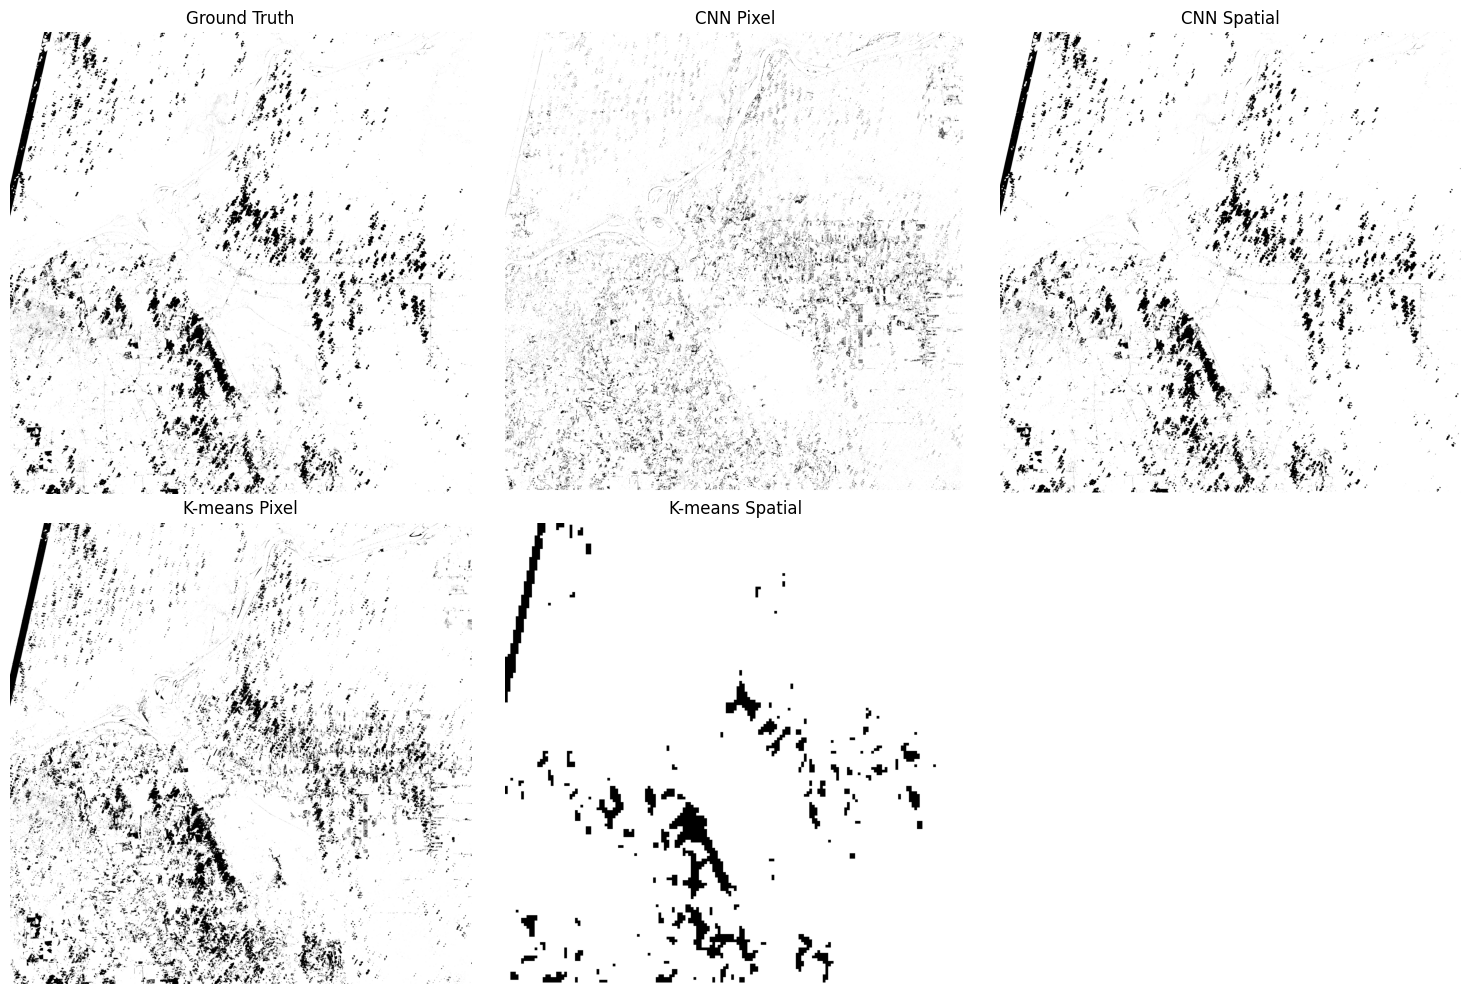

In [ ]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")

# --- Load Ground Truth ---
change_mask = np.load(os.path.join(save_dir, "change_mask.npy"))
H, W = change_mask.shape
change_mask_flat = change_mask.flatten().astype(np.uint8)

# --- Load Predictions ---
cnn_pixel_pred = np.load(os.path.join(save_dir, "cnn_pixel_predictions.npy")).flatten()
cnn_spatial_pred = np.load(os.path.join(save_dir, "cnn_spatial_predictions.npy")).flatten()
kmeans_pixel = np.load(os.path.join(save_dir, "kmeans_clusters_pixel.npy")).flatten()
kmeans_spatial = np.load(os.path.join(patch_save_dir, "kmeans_clusters_spatial.npy"))  # Patch grid

# --- Expand kmeans_spatial to full resolution ---
patch_size = 64
stride = 32
num_patches_y, num_patches_x = kmeans_spatial.shape

expanded_kmeans_spatial = np.zeros((H, W), dtype=np.float32)  # Changed from uint8 to float32
weight = np.zeros((H, W), dtype=np.float32)
for i in range(num_patches_y):
    for j in range(num_patches_x):
        y_start = i * stride
        x_start = j * stride
        y_end = y_start + patch_size
        x_end = x_start + patch_size
        expanded_kmeans_spatial[y_start:y_end, x_start:x_end] += kmeans_spatial[i,j]
        weight[y_start:y_end, x_start:x_end] += 1
expanded_kmeans_spatial = (expanded_kmeans_spatial / np.maximum(weight, 1)).round().astype(np.uint8)
kmeans_spatial_flat = expanded_kmeans_spatial.flatten()

# --- Binarize K-means Clusters ---
def map_clusters(cluster_array, ground_truth):
    acc0 = accuracy_score(ground_truth, (cluster_array == 0).astype(int))
    acc1 = accuracy_score(ground_truth, (cluster_array == 1).astype(int))
    return (cluster_array == 1).astype(int) if acc1 > acc0 else (cluster_array == 0).astype(int)

kmeans_pixel_bin = map_clusters(kmeans_pixel, change_mask_flat)
kmeans_spatial_bin = map_clusters(kmeans_spatial_flat, change_mask_flat)

# --- Evaluation Function ---
def evaluate_model(pred, true):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred, zero_division=0)
    rec = recall_score(true, pred, zero_division=0)
    f1 = f1_score(true, pred, zero_division=0)
    iou = jaccard_score(true, pred, zero_division=0)
    return acc, prec, rec, f1, iou

# --- Evaluate Models ---
models = {
    "CNN Pixel": cnn_pixel_pred,
    "CNN Spatial": cnn_spatial_pred,
    "K-means Pixel": kmeans_pixel_bin,
    "K-means Spatial": kmeans_spatial_bin
}

print("\n Final Model Evaluation Results:\n")
for model_name, pred in models.items():
    acc, prec, rec, f1, iou = evaluate_model(pred, change_mask_flat)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}\n")

# --- Visual Comparison ---
preds = {
    "Ground Truth": change_mask,
    "CNN Pixel": cnn_pixel_pred.reshape(H, W),
    "CNN Spatial": cnn_spatial_pred.reshape(H, W),
    "K-means Pixel": kmeans_pixel_bin.reshape(H, W),
    "K-means Spatial": kmeans_spatial_bin.reshape(H, W)
}

plt.figure(figsize=(15,10))
for idx, (name, img) in enumerate(preds.items()):
    plt.subplot(2,3,idx+1)
    plt.imshow(img, cmap='binary')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()


This code generates and visualises confusion matrices to evaluate the performance of different deforestation detection models against the ground truth change mask.

- **Loading Data**:  
  - The ground truth change mask and predictions from four models (CNN Pixel, CNN Spatial, K-means Pixel, K-means Spatial) are loaded from saved `.npy` files.
  - For the K-means Spatial model, the clustering results are reshaped (if needed) and expanded to the full image resolution by averaging overlapping patches, ensuring consistency with the ground truth dimensions.

- **Cluster Binarisation**:  
  - The `map_clusters` function determines which cluster (0 or 1) corresponds to deforestation by evaluating the agreement with the ground truth, ensuring that the binary maps correctly reflect deforested areas.

- **Model Organisation**:  
  - A dictionary `models` stores the flattened predictions for each model, mapped to their respective names for easy iteration.

- **Confusion Matrix Generation**:  
  - For each model, the `confusion_matrix` function computes the counts of true positives, false positives, true negatives, and false negatives.
  - `ConfusionMatrixDisplay` is used to plot each confusion matrix with a blue colour map for clarity, and the plots are displayed one by one with titles indicating the model name.

- **Purpose**:  
  - These confusion matrices provide a detailed view of the performance of each model, highlighting areas where they excel or struggle, such as distinguishing between actual deforestation and stable forest areas.

This final visualisation complements the earlier metrics (accuracy, precision, recall, F1, IoU) by providing an interpretable and concise summary of model performance in terms of classification outcomes.


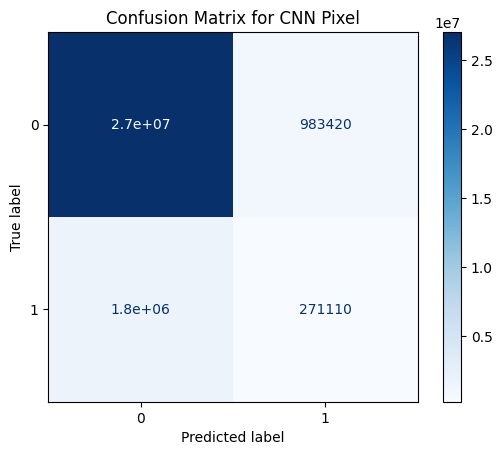

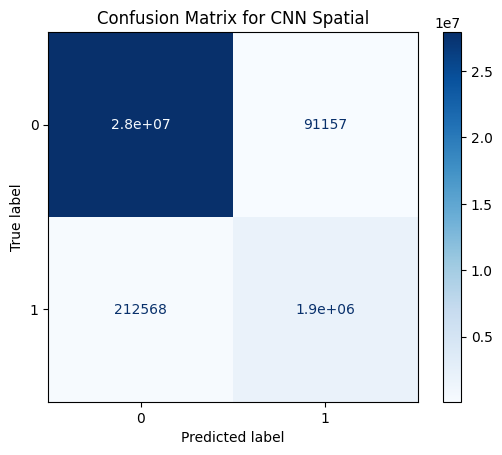

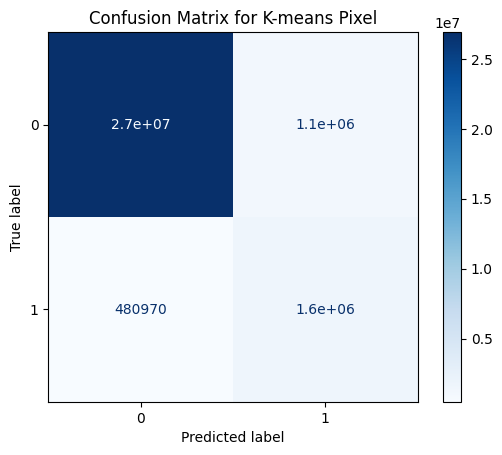

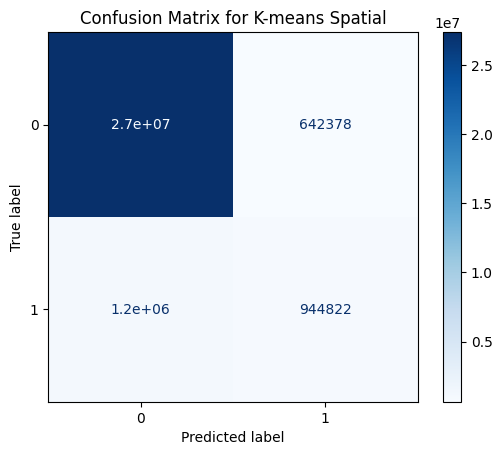

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Paths ---
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_save_dir = os.path.join(save_dir, "patches")

# --- Load Ground Truth ---
change_mask = np.load(os.path.join(save_dir, "change_mask.npy")).flatten().astype(np.uint8)
H, W = np.load(os.path.join(save_dir, "change_mask.npy")).shape
patch_size = 64
stride = 32

# --- Load Predictions ---
cnn_pixel_pred = np.load(os.path.join(save_dir, "cnn_pixel_predictions.npy")).flatten()
cnn_spatial_pred = np.load(os.path.join(save_dir, "cnn_spatial_predictions.npy")).flatten()
kmeans_pixel = np.load(os.path.join(save_dir, "kmeans_clusters_pixel.npy")).flatten()

# --- Load and Reshape K-means Spatial ---
kmeans_spatial_flat = np.load(os.path.join(patch_save_dir, "kmeans_clusters_spatial.npy"))
num_patches_y = (H - patch_size) // stride + 1
num_patches_x = (W - patch_size) // stride + 1

if kmeans_spatial_flat.ndim == 1:
    print("Reshaping kmeans_spatial from flat to grid.")
    kmeans_spatial = kmeans_spatial_flat.reshape(num_patches_y, num_patches_x)
else:
    kmeans_spatial = kmeans_spatial_flat

# --- Expand kmeans_spatial to match full resolution ---
expanded_kmeans_spatial = np.zeros((H, W), dtype=np.float32)
weight = np.zeros((H, W), dtype=np.float32)
for i in range(num_patches_y):
    for j in range(num_patches_x):
        y_start = i * stride
        x_start = j * stride
        y_end = y_start + patch_size
        x_end = x_start + patch_size
        expanded_kmeans_spatial[y_start:y_end, x_start:x_end] += kmeans_spatial[i,j]
        weight[y_start:y_end, x_start:x_end] += 1
expanded_kmeans_spatial = (expanded_kmeans_spatial / np.maximum(weight, 1)).round().astype(np.uint8)
kmeans_spatial_flat = expanded_kmeans_spatial.flatten()

# --- Binarize K-means Clusters ---
def map_clusters(cluster_array, ground_truth):
    acc0 = np.mean(ground_truth == (cluster_array == 0))
    acc1 = np.mean(ground_truth == (cluster_array == 1))
    return (cluster_array == 1).astype(int) if acc1 > acc0 else (cluster_array == 0).astype(int)

kmeans_pixel_bin = map_clusters(kmeans_pixel, change_mask)
kmeans_spatial_bin = map_clusters(kmeans_spatial_flat, change_mask)

# --- Models and Predictions ---
models = {
    "CNN Pixel": cnn_pixel_pred,
    "CNN Spatial": cnn_spatial_pred,
    "K-means Pixel": kmeans_pixel_bin,
    "K-means Spatial": kmeans_spatial_bin
}

# --- Generate Confusion Matrices ---
for model_name, pred in models.items():
    cm = confusion_matrix(change_mask, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


This code applies the trained CNN Spatial model to predict deforestation in the Congo region by comparing before and after NDVI images, and visualises and saves the resulting prediction map.

- **Reading and Resampling Bands**:  
  - The `read_band` function loads the NIR (B8A) and Red (B04) bands from the specified 20m and 10m resolution directories for both the before and after images.
  - The `resample_band` function ensures that bands from different resolutions are resampled to match the higher-resolution NIR band’s shape using average resampling.
  - NDVI is computed for both before and after images using the formula `(NIR - Red) / (NIR + Red + 1e-10)`.

- **Stacking NDVI Data**:  
  - The two NDVI images are stacked along the last axis to form a 2-channel input representing before and after NDVI.

- **Extracting Patches**:  
  - The code extracts overlapping patches (size 64x64, stride 32) from the stacked NDVI data, storing both the patches and their positions for later reconstruction.

- **Model Prediction**:  
  - The trained CNN Spatial model is loaded and used to predict deforestation probabilities for each extracted patch.
  - Binary predictions are obtained by thresholding the probabilities at 0.5.

- **Reconstructing the Full Image**:  
  - A zero-initialised array (`reconstructed`) is used to accumulate patch predictions, and a `weight` array tracks how many times each pixel is covered by patches.
  - The predictions are averaged and thresholded to produce a binary deforestation map for the full scene.

- **Saving and Visualisation**:  
  - The reconstructed deforestation prediction is saved as a `.npy` file.
  - A visualisation is generated using `matplotlib`, showing the predicted deforestation regions in binary colour, aiding interpretation.

This code provides an end-to-end workflow for applying the trained CNN Spatial model to unseen data, enabling the detection and mapping of deforestation in the Congo region based on Sentinel-2 NDVI imagery.


Extracted 28900 Congo Before-After patches.


904/904 ━━━━━━━━━━━━━━━━━━━━ 785s 868ms/step
Congo Before-After CNN Spatial prediction saved.


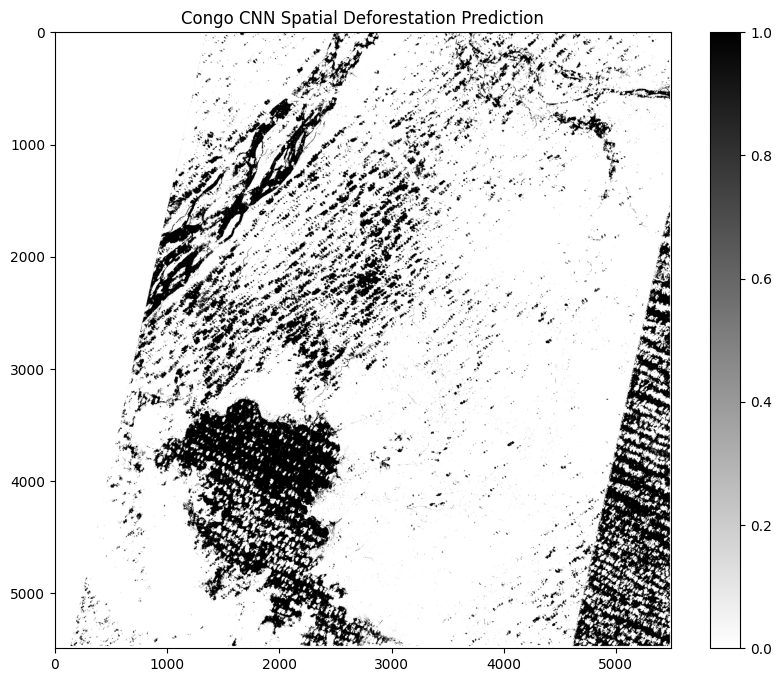

In [ ]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# --- Paths ---
congo_path_before_20m = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Congo_Before/GRANULE/L1C_T34MBE_A021268_20190719T090348/IMG_DATA"
congo_path_before_10m = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Congo_Before/GRANULE/L1C_T34MBE_A021268_20190719T090348/IMG_DATA"
congo_path_after_20m = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Congo_After/GRANULE/L1C_T33MZV_A031464_20210701T090332/IMG_DATA"
congo_path_after_10m = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/unzipped_products/Congo_After/GRANULE/L1C_T33MZV_A031464_20210701T090332/IMG_DATA"
save_dir = "/content/drive/MyDrive/AI_for_Earth_Observations/Independent Project/Data1/training_data"
patch_size = 64
stride = 32

# --- Read and Resample Bands ---
def read_band(band_dir, band_name):
    for file in os.listdir(band_dir):
        if band_name in file:
            path = os.path.join(band_dir, file)
            with rasterio.open(path) as src:
                data = src.read(1).astype('float32')
                return data, path
    print(f"{band_name} not found in {band_dir}")
    return None, None

def resample_band(band_path, target_shape):
    with rasterio.open(band_path) as src:
        data = src.read(
            out_shape=(src.count, target_shape[0], target_shape[1]),
            resampling=Resampling.average
        )[0]
    return data.astype('float32')

# --- Load Congo_After Bands ---
nir_after, nir_after_path = read_band(congo_path_after_20m, "B8A.jp2")
red_after, red_after_path = read_band(congo_path_after_10m, "B04.jp2")
red_after_resampled = resample_band(red_after_path, nir_after.shape)
ndvi_after = (nir_after - red_after_resampled) / (nir_after + red_after_resampled + 1e-10)

# --- Load Congo_Before Bands ---
nir_before, nir_before_path = read_band(congo_path_before_20m, "B8A.jp2")
red_before, red_before_path = read_band(congo_path_before_10m, "B04.jp2")
red_before_resampled = resample_band(red_before_path, nir_before.shape)
ndvi_before = (nir_before - red_before_resampled) / (nir_before + red_before_resampled + 1e-10)

# --- Ensure shapes match ---
if ndvi_before.shape != ndvi_after.shape:
    raise ValueError("NDVI Before and After shapes do not match.")

H, W = ndvi_before.shape
ndvi_stack_congo = np.stack([ndvi_before, ndvi_after], axis=-1)

# --- Extract Patches ---
patches_X, positions = [], []
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        patch = ndvi_stack_congo[i:i+patch_size, j:j+patch_size, :]
        if patch.shape[:2] == (patch_size, patch_size):
            patches_X.append(patch)
            positions.append((i, j))
patches_X = np.array(patches_X)
print(f"Extracted {len(patches_X)} Congo Before-After patches.")

# --- Load CNN Spatial Model ---
cnn_model_spatial = load_model(os.path.join(save_dir, "cnn_model_spatial.h5"))

# --- Predict ---
pred_patches = cnn_model_spatial.predict(patches_X)
pred_patches_binary = (pred_patches > 0.5).astype(np.uint8)

# --- Reconstruct Full Prediction ---
reconstructed = np.zeros((H, W, 1))
weight = np.zeros((H, W, 1))
for (i, j), patch_pred in zip(positions, pred_patches_binary):
    reconstructed[i:i+patch_size, j:j+patch_size, :] += patch_pred
    weight[i:i+patch_size, j:j+patch_size, :] += 1
reconstructed = (reconstructed / np.maximum(weight, 1))
congo_pred = (reconstructed[..., 0] > 0.5).astype(np.uint8)

# --- Save Prediction ---
np.save(os.path.join(save_dir, "congo_before_after_cnn_spatial_pred.npy"), congo_pred)
print("Congo Before-After CNN Spatial prediction saved.")

# --- Visualize ---
plt.figure(figsize=(10,8))
plt.imshow(congo_pred, cmap='binary')
plt.title("Congo CNN Spatial Deforestation Prediction")
plt.colorbar()
plt.show()


This code stops the carbon emissions tracking session initiated earlier using the `codecarbon` tracker, retrieves the estimated emissions data, and prints the result.

- The `tracker.stop()` method stops the emissions tracking, returning the estimated carbon dioxide equivalent (CO₂eq) emissions produced during the tracked code execution.
- The result, representing the estimated environmental impact of the computations, is formatted to four decimal places and printed as a summary message.

This provides a clear and measurable insight into the environmental footprint of running the notebook’s code, promoting awareness of computational sustainability.


In [ ]:
# Stop tracking
emissions = tracker.stop()
print(f"Estimated CO2 Emissions: {emissions:.4f} kg CO2eq")

Estimated CO2 Emissions: 0.0023 kg CO2eq
